In [314]:
import numpy as np
import matplotlib.pyplot as plt
from LIBS_handler import LIBS_Toolkit
from RAMAN_handler import Raman_toolkit
from skimage.transform import rotate

In [315]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload 1
%autoreload 2

# 1. Data Handler Inits

In [ ]:
fname_raman = r"E:/Data/Data_Raman/HDR/Quadrado/20231211_ 927.h5"
fname_libs = r"E:/Data/Data_LIBS/HDR/rock2_355_map"

libs_tools = LIBS_Toolkit(fname_libs, overwrite = True)
raman_tools = Raman_toolkit(fname_raman, overwrite = True)

## 1.1 Load Data

In [ ]:
libs_tools.load_dataset(baseline_corrected = False)
raman_tools.load_dataset()

## 1.2 Pre-processing

In [ ]:
_ = libs_tools.baseline_correct()
_ = raman_tools.baseline_correct()

## 1.3 Extract Features

In [ ]:
wl = [610.22, 460.28, 568.77, 819.40]
wn = [509, 464, 490, 705]

_=libs_tools.manual_features(wl, sigma = 0.8)
_=raman_tools.manual_features(wn, sigma = 0.5)

In [ ]:
modality1 = raman_tools.features[3]
modality2 = libs_tools.features[0]

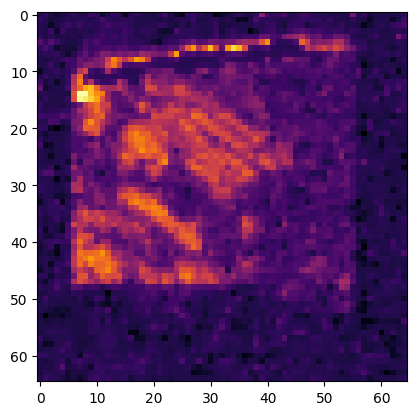

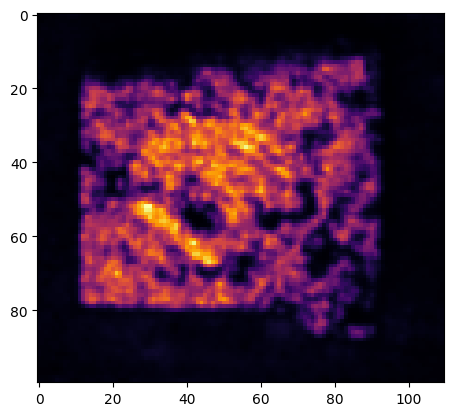

In [ ]:
plt.figure()
plt.imshow(modality1, cmap = 'inferno')

plt.figure()
plt.imshow(modality2, cmap = 'inferno')

# 2. Image Registration

## 2.1 Set to same scale

Instead of performing scale optimization using mutual information we will start by setting both images to the same scale. In this case we will use the Raman resolution as the default mesh, and the LIBS dataset will be interpolated to that mesh.

In [ ]:
from scipy.interpolate import RegularGridInterpolator

def interpolator(array_to_interpolate, x_input, y_input, x_output, y_ouput, method = 'nearest'):
        interp = RegularGridInterpolator(
            points = [x_input, y_input],
            values = np.transpose(array_to_interpolate),
            bounds_error = False,
            fill_value = 0,
            method = method
        )

        X_output, Y_ouput = np.meshgrid(x_output, y_ouput, indexing = 'ij')
        arr_out = np.transpose(interp((X_output, Y_ouput)))
        return arr_out

res_libs = 0.25
res_raman = 0.4

x_raman, y_raman = np.arange(0, raman_tools.x_size*res_raman, res_raman), np.arange(0, raman_tools.y_size*res_raman, res_raman)
x_libs, y_libs = np.arange(0, libs_tools.x_size*res_libs, res_libs), np.arange(0, libs_tools.y_size*res_libs, res_libs)

modality2_scaled = interpolator(modality2, y_libs, x_libs, y_raman, x_raman, method = 'nearest')

In [ ]:
x_pad = modality2.shape[0] - modality1.shape[0]
y_pad = modality2.shape[1] - modality1.shape[1]

modality1_newsize = np.pad(modality1, pad_width = ((0, x_pad), (0, y_pad)))
modality1_newsize.shape

(100, 110)

## 2.2 Maximize Mutual Information

Here we only need to optimize rotation and translation

In [ ]:
from MI import MI
import torch

In [ ]:
from torchvision.transforms.functional import affine
from torchvision.transforms import InterpolationMode

modality1 = np.array(modality1) # numpy array of shape (nx, ny)
modality2_scaled = np.array(modality2_scaled) # numpy array of shape (nx, ny)

def affine_image(img, rot_angle, translate):
    fixed = affine(torch.tensor(img).unsqueeze(0), 
                angle = rot_angle, translate = translate, 
                scale = 1, 
                shear = 0,
                interpolation = InterpolationMode.NEAREST)
    return fixed.squeeze(0).detach().numpy()

In [ ]:
from scipy.optimize import minimize

def optimize_affine_transform(original_image, target_image):
    mutual_info = MI(dimension = 2, num_bins = 64, kernel_sigma = 1)

    # Initial guess for the parameters
    initial_params = {
        'rot_angle': 0,
        'translate': [0, 0]
    }

    def objective_function(params):
        rot_angle = params['rot_angle']
        translate = params['translate']
        fixed_image = affine_image(original_image, rot_angle, translate)
        return -mutual_info.mi(torch.tensor(fixed_image).unsqueeze(0).unsqueeze(0),
                               torch.tensor(target_image).unsqueeze(0).unsqueeze(0))

    def scipy_objective_function(param_list):
        # Convert the flat list back to dictionary
        params = {
            'rot_angle': param_list[0],
            'translate': [param_list[1], param_list[2]]
        }
        return objective_function(params)

    rot_angle_range = np.linspace(0, 270, 4)
    best_result = None
    best_params = None

    for rot_angle in rot_angle_range:
        initial_guess = [rot_angle, initial_params['translate'][0], initial_params['translate'][1]]
        result = minimize(scipy_objective_function, initial_guess, method='Powell')
        # result = minimize(scipy_objective_function, initial_guess, method = 'BFGS')
        print(f'Rotation - {rot_angle}, minimum is: {result.fun:.2f}')
        if best_result is None or result.fun < best_result.fun:
            best_result = result
            best_params = {
                'rot_angle': result.x[0],
                'translate': [result.x[1], result.x[2]]
            }
    return best_params

In [ ]:
optim_params = optimize_affine_transform(modality2_scaled, modality1)
optim_params

Rotation - 0.0, minimum is: 0.63
Rotation - 90.0, minimum is: 0.79
Rotation - 180.0, minimum is: 0.70
Rotation - 270.0, minimum is: 0.71


{'rot_angle': 1.2570681256267573,
 'translate': [-1.955186217284975, -1.1696568135349048]}

In [ ]:
rot_angle = optim_params['rot_angle']
translate = optim_params['translate']

new_mod2 = affine_image(modality2_scaled, rot_angle, translate)

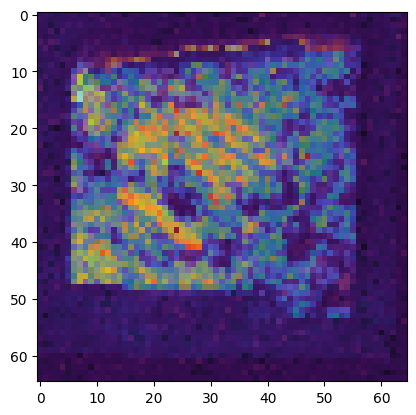

In [ ]:
plt.figure()
plt.imshow(modality1, cmap = 'inferno')
plt.imshow(new_mod2, cmap = 'turbo', alpha = 0.5)

## 2.4 Attempt to use scaling

In [ ]:
from torchvision.transforms.functional import affine
from torchvision.transforms import InterpolationMode

modality1 = np.array(modality1) # numpy array of shape (nx, ny)
modality2_scaled = np.array(modality2_scaled) # numpy array of shape (nx, ny)

def affine_image(img, rot_angle, translate, scale):
    fixed = affine(torch.tensor(img).unsqueeze(0), 
                angle = rot_angle, translate = translate, 
                scale = scale, 
                shear = 0,
                interpolation = InterpolationMode.NEAREST)
    return fixed.squeeze(0).detach().numpy()

In [ ]:
from scipy.optimize import minimize

def optimize_affine_transform(to_transform, target_image):
    mutual_info = MI(dimension = 2, num_bins = 64, kernel_sigma = 1)

    # Initial guess for the parameters
    initial_params = {
        'rot_angle': 0,
        'translate': [0, 0],
        'scale': 1
    }

    def objective_function(params):
        rot_angle = params['rot_angle']
        translate = params['translate']
        scale = params['scale']
        fixed_image = affine_image(to_transform, rot_angle, translate, scale)
        return -mutual_info.mi(torch.tensor(fixed_image).unsqueeze(0).unsqueeze(0),
                               torch.tensor(target_image).unsqueeze(0).unsqueeze(0))

    def scipy_objective_function(param_list):
        # Convert the flat list back to dictionary
        params = {
            'rot_angle': param_list[0],
            'translate': [param_list[1], param_list[2]],
            'scale': param_list[3]
        }
        return objective_function(params)

    rot_angle_range = np.linspace(0, 270, 4)
    best_result = None
    best_params = None

    for rot_angle in rot_angle_range:
        initial_guess = [rot_angle, initial_params['translate'][0], initial_params['translate'][1], initial_params['scale']]

        rot_angle_bounds = (rot_angle-45, rot_angle+45)  # Assuming rotation is in degrees
        translate_bounds_x = (-50, 50)  # Example translation bounds in the x-direction
        translate_bounds_y = (-50, 50)  # Example translation bounds in the y-direction
        scale_bounds = (0.3, 2.5)  # Example translation bounds in the y-direction

        # Combine all bounds in a list (order must match the parameter list order)
        bounds = [rot_angle_bounds, translate_bounds_x, translate_bounds_y, scale_bounds]

        result = minimize(scipy_objective_function, initial_guess, method='Powell', bounds = bounds)
        # print(f'{rot_angle} - Error: {result:.2f}', end = '\r')
        if best_result is None or result.fun < best_result.fun:
                    best_result = result
                    best_params = {
                        'rot_angle': result.x[0],
                        'translate': [result.x[1], result.x[2]],
                        'scale': result.x[3]
                    }
    return best_params

In [ ]:
optim_params = optimize_affine_transform(modality1_newsize, modality2)
optim_params

{'rot_angle': 185.5284987435971,
 'translate': [-28.07400485086325, -27.69254114413899],
 'scale': 1.1333612251587961}

In [ ]:
rot_angle = optim_params['rot_angle']
translate = optim_params['translate']
scale = optim_params['scale']

new_mod1 = affine_image(modality1_newsize, rot_angle, translate, scale)

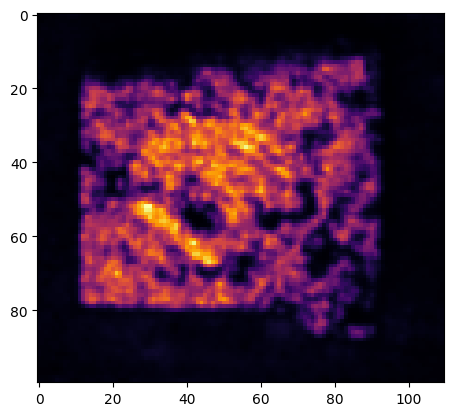

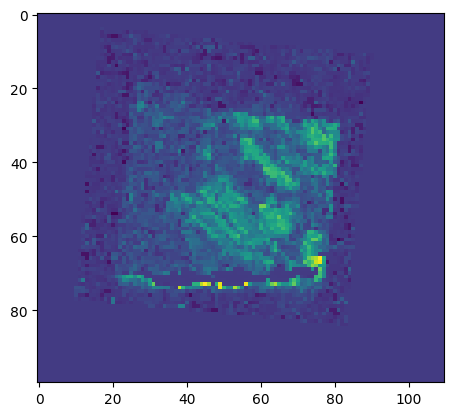

In [ ]:
plt.figure()
plt.imshow(modality2, cmap = 'inferno')

plt.figure()
plt.imshow(new_mod1, cmap = 'viridis', alpha = 1)

# 3. Pytorch Implementation

Pytorch is a deep learning framework that allows for loss optimiaztion using gradient descent. That means all the functions through which our parameters flow must allow for gradient optimization. While that is already the case for our Mutual Information implementation, the affine transform function as it stands, doesn't allow for gradients, meaning it need modifications.

In [382]:
modality1_newsize_torch = torch.tensor(modality1_newsize, dtype = torch.float32)
modality2_torch = torch.tensor(modality2, dtype = torch.float32)

In [507]:
import torch
from torch import nn
from torch.functional import F
import torch.optim.lr_scheduler as lr_scheduler

In [554]:
class AffineTransform(nn.Module):
    def __init__(self, scale=1., transX=0., transY=0., angle=0., device='cpu'):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(scale, dtype=torch.float, device=device))
        self.transX = nn.Parameter(torch.tensor(transX, dtype=torch.float, device=device))
        self.transY = nn.Parameter(torch.tensor(transY, dtype=torch.float, device=device))
        self.angle = nn.Parameter(torch.tensor(angle, dtype=torch.float, device=device))
        self.device = device

    def get_theta(self):
        cos_angle = torch.cos(self.angle)
        sin_angle = torch.sin(self.angle)
        return torch.stack([
            torch.cat([(self.scale * cos_angle).unsqueeze(0), (-self.scale * sin_angle).unsqueeze(0), self.transX.unsqueeze(0)]),
            torch.cat([(self.scale * sin_angle).unsqueeze(0), (self.scale * cos_angle).unsqueeze(0), self.transY.unsqueeze(0)])
        ]).unsqueeze(0)

    def forward(self, x):
        theta = self.get_theta()
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        return F.grid_sample(x, grid, align_corners=False)

def optimize_affine_transform_pytorch(to_transform, target_image, rot_angle_range, device='cpu'):
    mutual_info = MI(dimension=2, num_bins=64, kernel_sigma=1).to(device)

    best_params = None
    best_loss = float('inf')

    # Convert images to torch tensors and move to specified device
    to_transform = to_transform.unsqueeze(0).unsqueeze(0).float().to(device)
    target_image = target_image.unsqueeze(0).unsqueeze(0).float().to(device)

    for rot_angle in rot_angle_range:
        # Initialize the affine transform module
        model = AffineTransform(scale=1.0, transX=0.0, transY=0.0, angle=rot_angle, device=device)
        optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1)
        scheduler = lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 1e-2, total_iters = 80)

        for _ in range(100):
            optimizer.zero_grad()
            transformed_image = model(to_transform)
            loss = -mutual_info.mi(transformed_image, target_image)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            if loss.item() < best_loss:
                print(loss.item(), end='\r')
                best_loss = loss.item()
                best_params = {
                    'rot_angle': model.angle.item(),
                    'translate': [model.transX.item(), model.transY.item()],
                    'scale': model.scale.item()
                }

    return best_params, model

In [555]:
device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
rot_angle_range = np.linspace(0, 3*np.pi/2, 4)
best_params, mode = optimize_affine_transform_pytorch(modality1_newsize_torch, modality2_torch, rot_angle_range, device = device)
print(best_params)

{'rot_angle': -0.010439419187605381, 'translate': [-0.40615493059158325, -0.39520925283432007], 'scale': 0.6151065826416016}


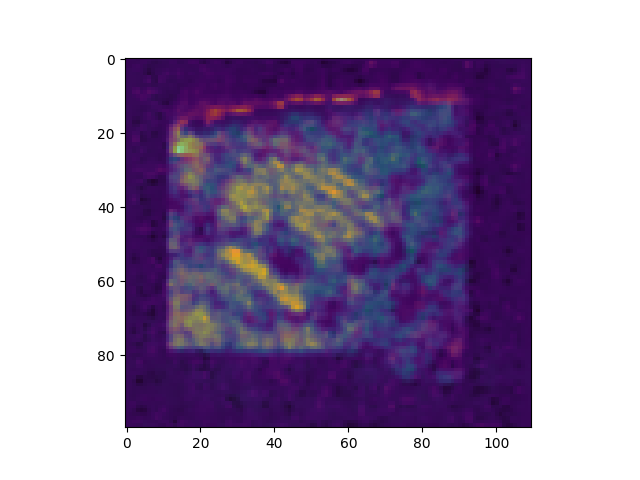

In [556]:
scale = best_params['scale']
angle = best_params['rot_angle']
tx = best_params['translate'][0]
ty = best_params['translate'][1]

affine_final = AffineTransform(scale, tx, ty, angle)
transformed_image = affine_final(modality1_newsize_torch.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy()

plt.figure()
plt.imshow(modality2, cmap  = 'viridis')
plt.imshow(transformed_image, alpha = 0.5, cmap = 'inferno')